# Talking to the Duet, and USB in WSL

I wanted to talk over serial to this duet 3D printer control board, but initially had issues since it didn't show up in the device list in WSL. TIL: you can share devices but need to run a few commands in powershell admin or similar on the windows side first. Here I document that and then try out some gcode. A version of this notebook is available on [github](https://github.com/johnowhitaker/duet_fun).

## Device Specs

This is a Duet V0.8.5 controller board.

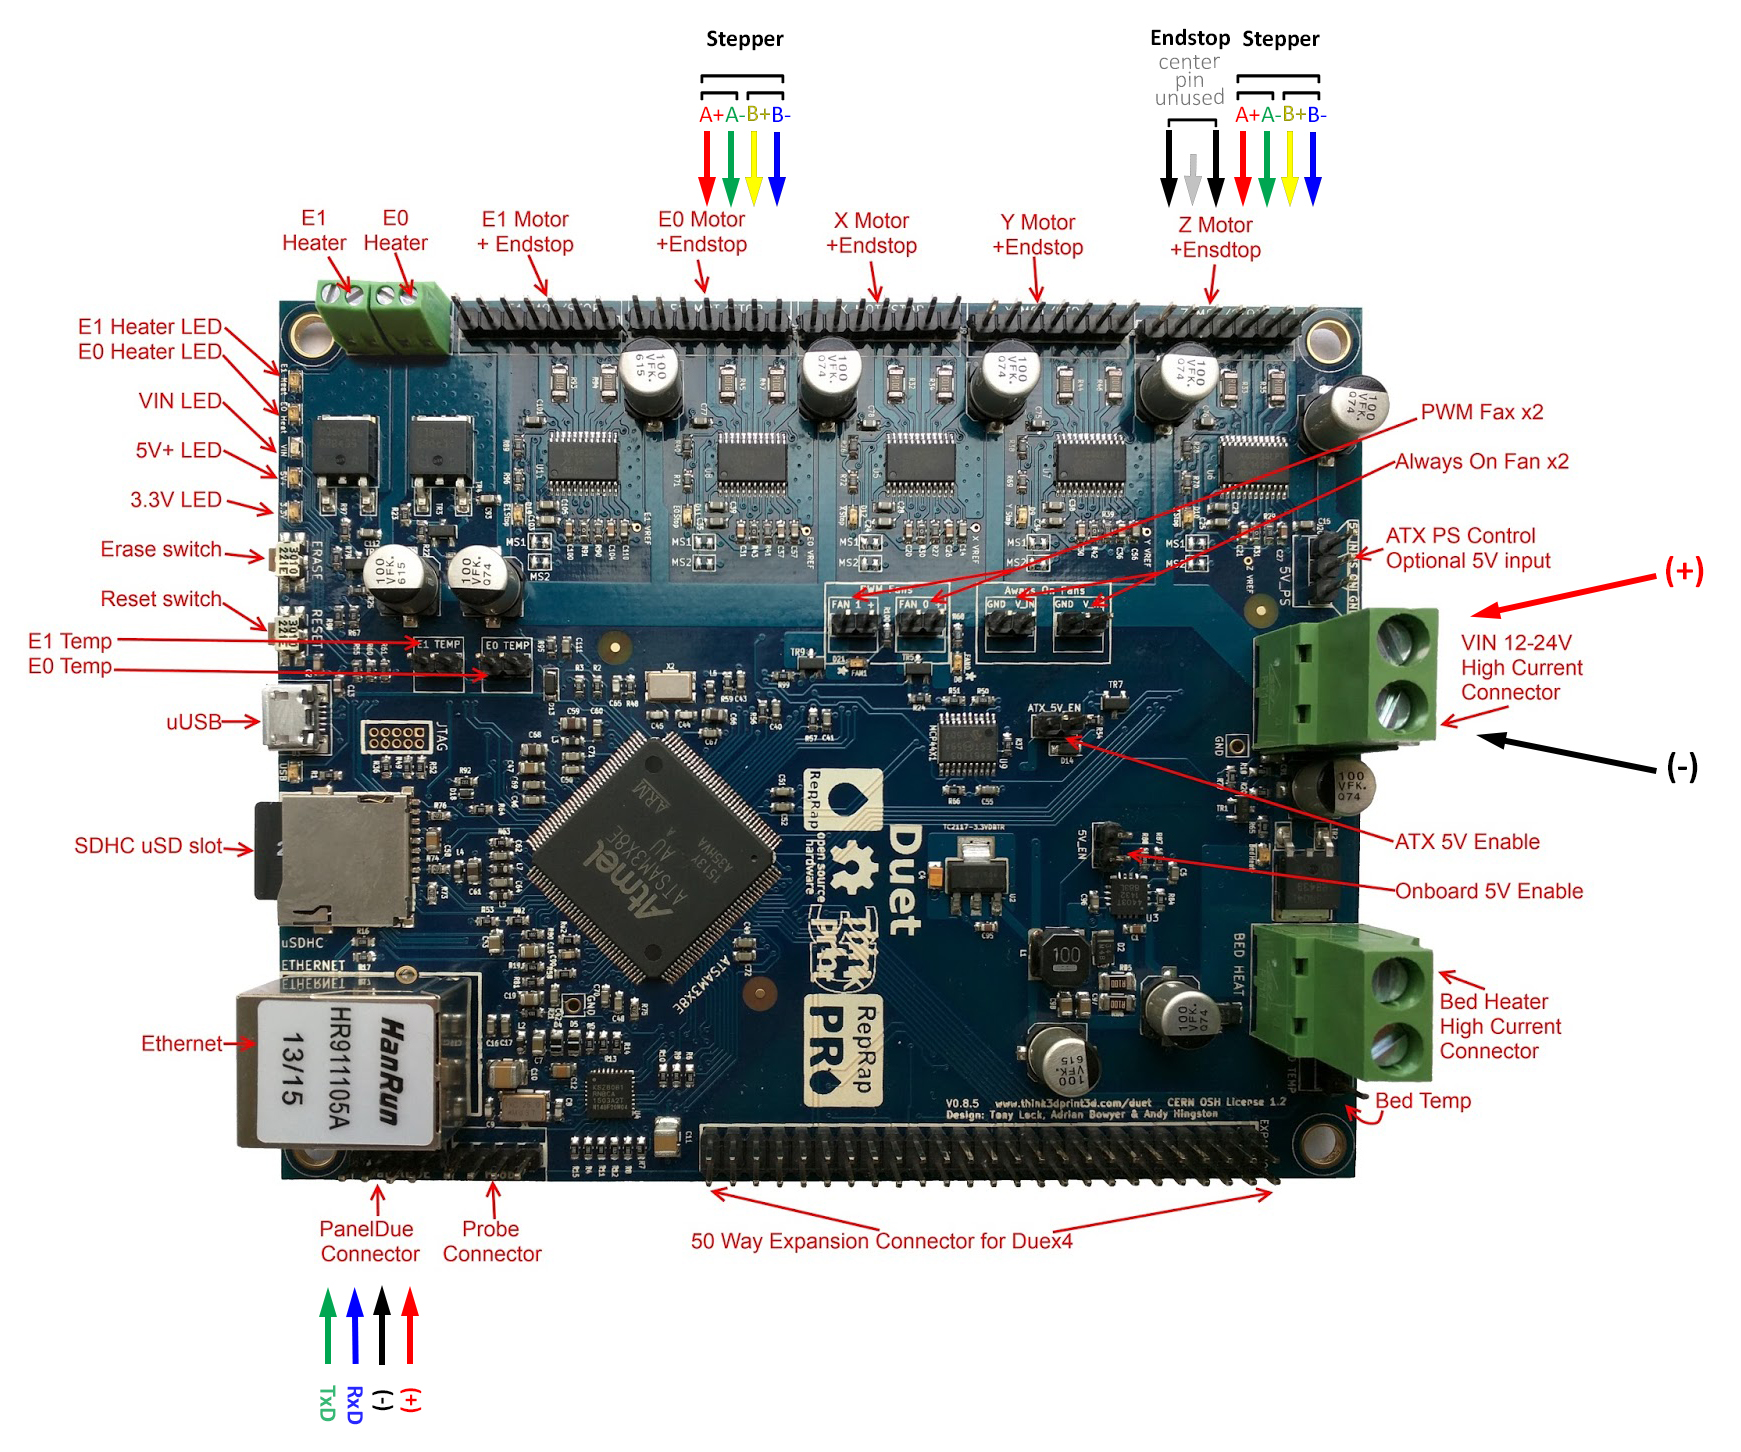

It's running `RepRapFirmware for Duet Version 1.15e dated 2016-10-02`

## Sharing with WSL

I want to run this notebook in my dev environment in Linux under WSL. So, in an admin powershell, I ran:

```
PS C:\Windows\System32> usbipd list
Connected:
BUSID  VID:PID    DEVICE                                                        STATE
3-8    0e8d:0608  RZ608 Bluetooth(R) Adapter                                    Not shared
3-10   03eb:2404  USB Serial Device (COM5)                                      Not shared
3-14   0b05:19af  AURA LED Controller, USB Input Device                         Not shared
3-17   1b1c:0c32  USB Input Device                                              Not shared
4-4    0fd9:0078  Elgato Facecam, USB Input Device                              Not shared
8-3    046d:c52b  Logitech USB Input Device, USB Input Device                   Not shared
8-4    045e:07a5  USB Input Device                                              Not shared
9-3    0763:3105  Code 49, USB Input Device                                     Not shared

Persisted:
GUID                                  DEVICE

PS C:\Windows\System32> usbipd bind --busid 3-10
PS C:\Windows\System32> usbipd attach --wsl --busid 3-10
usbipd: info: Using WSL distribution 'Ubuntu' to attach; the device will be available in all WSL 2 distributions.
usbipd: info: Using IP address 172.27.128.1 to reach the host.
PS C:\Windows\System32>
```

This then made it show up as an available serial device.

## Connect over Serial

In [ ]:
import serial, time

In [ ]:
!ls /dev/ttyACM*

/dev/ttyACM0


In [ ]:
ser = serial.Serial('/dev/ttyACM0', 115200, timeout=1)

In [ ]:
ser.write(b'M115\n')
response = ""
while True:
    chunk = ser.read(1000).decode('ascii', errors='ignore')
    if not chunk: break
    response += chunk
print(response)

In [ ]:
def send_gcode(command, ser, wait=0.2):
    """Send a single G-code command to the Duet and return the response."""
    cmd_str = command.strip() + '\n'
    ser.write(cmd_str.encode('ascii'))
    time.sleep(wait)  # Wait a bit for the Duet to process and respond
    response = ""
    while True:
        chunk = ser.read(1000).decode('ascii', errors='ignore')
        if not chunk: break
        response += chunk
    return response

In [ ]:
res = send_gcode("M115", ser)
print("Response from M115:", res)

Response from M115: FIRMWARE_NAME: RepRapFirmware for Duet FIRMWARE_VERSION: 1.15e ELECTRONICS: Duet 0.85 DATE: 2016-10-02
ok



## Available Commands

In [ ]:
temp_report = send_gcode("M105", ser)
print("Temperature report (M105):")
print(temp_report)

In [ ]:
endstop_report = send_gcode("M119", ser)
print("Endstop report (M119):")
print(endstop_report)

In [ ]:
# Move X axis to 10 mm at 6000 mm/min
move_response = send_gcode("G1 X10 F6000", ser)
print("Move response:", move_response)

In [ ]:
# Turn on Fan0 at full speed
fan_response = send_gcode("M106 P0 S255", ser)
print("Turn on Fan0 response:", fan_response)

# Turn fan down to half speed
fan_half = send_gcode("M106 P0 S128", ser)
print("Fan0 half speed:", fan_half)

# Turn fan off
fan_off = send_gcode("M107 P0", ser)
print("Turn off Fan0:", fan_off)

In [ ]:
# Move to X=20, Y=20, Z=5 at 6000mm/min feedrate
move_response = send_gcode("G1 X20 Y20 Z5 F6000", ser)
print("Move response:", move_response)

In [ ]:
# # Set extruder (Tool 0) to 200 C
# heat_extruder = send_gcode("M104 S200 T0", ser)
# print("Heat extruder response:", heat_extruder)

# # Wait a few seconds, then read temperature
# time.sleep(5)
# print("Temp after setting extruder to 200C:", send_gcode("M105", ser))

# # Turn off extruder heater
# off_extruder = send_gcode("M104 S0 T0", ser)
# print("Extruder off response:", off_extruder)

In [ ]:
# home_response = send_gcode("G28", ser)
# print("Homing response:", home_response)

In [ ]:
# Disable all stepper motors using M18 command
# disable_response = send_gcode("M18", ser)
# print("Disable steppers response:", disable_response)

In [ ]:
# Set 0 position
for axis in ['X', 'Y', 'Z']:
    print(send_gcode(f"G92 {axis}0", ser))

pos = send_gcode("M114", ser)
print("\nCurrent positions after homing:", pos)

# Re-enable steppers
# send_gcode("M17", ser)

## Stored GCODE

In [ ]:
print("Mount SD card:")
print(send_gcode("M21", ser))
print("\nList files:")
print(send_gcode("M20", ser))

Mount SD card:
SD card mounted in slot 0, capacity 1.83Gb
ok


List files:
Begin file list
song1.gcode
End file list
ok



In [ ]:
# Play the song
send_gcode('M32 song1.gcode',ser)

'Done printing file\nFile opened\nFile selected\nok\nDrive X does not support 1x microstepping\n'

In [ ]:
# Unmount the card
print(send_gcode("M22", ser))

Done printing file
ok



In [ ]:
ser.close()

## Configuring

I used https://configtool.reprapfirmware.org/legacy

Typically, RepRapFirmware stores its configuration files (like config.g) on the SD card. On older Duet boards (like the 0.8.5), you can configure nearly everything by editing these files. If the firmware is currently set up for a delta printer, you’ll likely see delta-specific homing sequences, etc. Here’s the general workflow:

### 1. Remove and examine the SD card

Power down the board (unplug USB, power supply, etc.).
Take out the SD card from the Duet and put it into your PC (via an SD card adapter).
You should see files like config.g, homex.g, homey.g, homez.g, homeall.g, and possibly others (macros, etc.).
config.g is the main configuration file that runs at startup. This is where you’ll see things like:

Motor steps per mm (M92)
Stepper drivers, current settings (M906)
Kinematics type (e.g. M665 for delta)
Endstop configuration (M574 statements)
Temperature sensor definitions (M305 or M308)
Network config, etc.

### 2. Editing config.g

Open config.g in a text editor. You’ll see something like:

```rust
; Configuration file for delta
M665 R123.45 L240.0 ...
M666 X0 Y0 Z0
; etc...
```

That’s the delta-specific section. If you want to switch to, say, a Cartesian or CoreXY, you’d remove these delta settings and specify the correct kinematics, typically with:

```
M667 S0 ; Cartesian mode
or

M667 S1 ; CoreXY mode
…and so on.
```

You’ll also see motor mapping lines like:

```python
M569 P0 S1 ; Drive 0 goes forwards
M569 P1 S0 ; Drive 1 goes reversed
...
```

These specify which motor port is used for X, Y, Z, extruders, etc., and their directions.

Additionally, look for:

```
; Axis Limits
M208 X0 Y0 Z0 S1    ; set minimum
M208 X200 Y200 Z200 S0 ; set maximum
```

for Cartesian. For a delta, you’ll see different commands.

Key commands for a typical Cartesian 3D printer or CNC:

```
M92 (steps/mm)
M203 (max feedrate)
M201 (acceleration)
M566 (jerk)
M906 (motor currents)
```

### 3. Homing Files

Look for homex.g, homey.g, homez.g, and/or homeall.g. These specify the sequence of moves when you run G28 or G28 X, G28 Y, etc. For a delta, you’ll see big “tower homing” moves. For a Cartesian, you’ll typically see something like:

```
G91                ; relative moves
G1 Z5 F6000 H2     ; lift Z to avoid collisions
G1 X-305 F3000 S1  ; move left until X endstop triggered
```
etc. You’d want to adjust these for your hardware layout—motor directions, endstop positions, etc.

### 4. Using the RepRapFirmware Configuration Tool

An easy way to start fresh is:

Go to the Duet3D Configuration Tool.
Select “Duet 0.8.5”, the type of machine (Cartesian, CoreXY, etc.), your motor specs, endstop locations, etc.
It will generate a zip file with config.g, homing files, macros, etc.
Copy those onto your SD card’s sys/ folder (after backing up the old files).
Put the SD card back into the Duet, power it up, and you should have a fresh config tailored to your hardware.

### 5. Testing and Iterating

Once you have a new or edited config.g:

Power on the board (with the SD card inserted).
Connect via USB and send an M115 just to verify the firmware is alive.
Use commands like:
M98 P"config.g" to re-run your config file.
M503 to report the current configuration.
If something goes wrong (e.g., endstop triggers in reverse), adjust the config again.
Keep an eye on the console for error messages or warnings.

### 6. Summary

All configuration is on the SD card in config.g and related .g files.
If it’s currently set up for a delta, you can manually edit or regenerate the files to suit a different machine type.
The official Duet documentation has references for all relevant G/M-codes and a step-by-step guide on configuring the older boards.
For a brand-new config, the online RepRapFirmware config tool is the easiest starting point.
Once you’ve set up the correct configuration, you can treat the Duet 0.8.5 like any other Duet board: send G-code commands from USB/serial or from a web interface (if you enable network features), and it’ll behave according to your config.g settings.

**If I put .gcode files on the SD is there a command I can send over serial to run one of them?**

Yes—you can use M32. That G-code command starts a print (or “run”) of a file on the SD card. For example:

```
M32 my_great_print.gcode
```
That will load and start executing my_great_print.gcode from the SD card.

If you’re dealing with macro (non-print) files—say, short scripts you keep in the sys/ or macros/ folder—then M98 is the standard command to call those. For example:

```
M98 P"my_macro.g"
```

But for normal .gcode files that you’d like to “print” (execute all G- and M-codes in the file), M32 is what you want.